# **1. 환경 세팅**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%ls gdrive/MyDrive/생체

001_00.png  002_00.png  bin_fingerprint.jpg  results/


In [ ]:
!pip install numpy opencv-python

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
img=cv2.imread('/content/gdrive/MyDrive/생체/002_00.png')
print(img)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


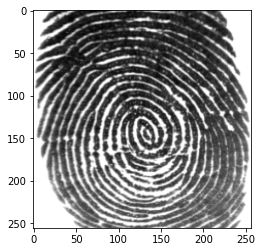

In [ ]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')

# **2. 이진화**

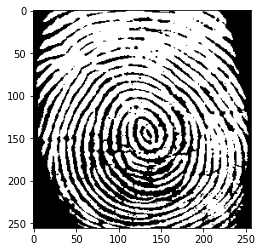

In [ ]:
img_zero = np.zeros((256, 256), dtype=np.uint8) # char
img_zero[img_gray > 128] = 100
img_bin = 256 - img_zero
plt.imshow(img_bin, cmap='gray')

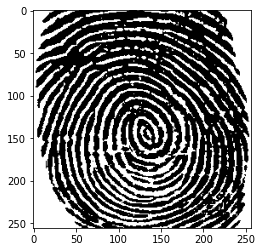

In [ ]:
src=img_gray

# 지역 이진화
dst2 = np.zeros(src.shape, np.uint8) # 검정색 영상

# 넓이 / 16, 높이 / 16
bw = src.shape[1] // 16
bh = src.shape[0] // 16

# 가로 세로 16등분
for y in range(16):
    for x in range(16):
        src_ = src[y*bh:(y+1)*bh, x*bw:(x+1)*bw]   # threshold 입력값으로 주기 위해 입력 영상도 등분
        dst_ = dst2[y*bh:(y+1)*bh, x*bw:(x+1)*bw] # dst_를 변경하면 dst2도 변경됨
        
        cv2.threshold(src_, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU, dst_)
        
# 결과 출력
plt.imshow( dst2, cmap='gray')

001_00.png  002_00.png  bin_fingerprint.jpg  results/


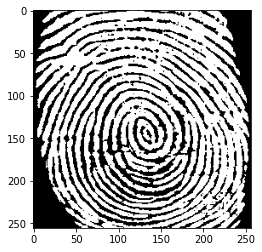

In [ ]:
img_zero = np.zeros((256, 256), dtype=np.uint8) # char
img_zero[dst2 > 128] = 100
img_src = 256 - img_zero
plt.imshow(img_src, cmap='gray')
cv2.imwrite('./gdrive/MyDrive/생체/bin_fingerprint.jpg', img_src)
%ls gdrive/MyDrive/생체

# **3. 세선화**

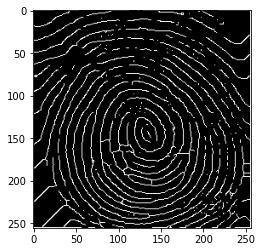

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import cv2
import numpy as np
import matplotlib.cm as cm
import scipy.signal as signal
from skimage import img_as_ubyte
"load image data"
Img_Original =  io.imread('./gdrive/MyDrive/생체/bin_fingerprint.jpg', as_gray=True)     # Gray image, rgb images need pre-conversion
"Convert gray images to binary images using Otsu's method"
from skimage.filters import threshold_otsu
Otsu_Threshold = threshold_otsu(Img_Original)
BW_Original = Img_Original < Otsu_Threshold    # must set object region as 1, background region as 0

def neighbours(x,y,image): #returm 8 numbers
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2      [0:1] P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2) 0->1

def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape
        for x in range(1, rows - 1):    
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Conditions:
                    2 <= sum(n) <= 6   and
                    transitions(n) == 1 and
                    P2 * P4 * P6 == 0  and
                    P4 * P6 * P8 == 0):
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0   #delete
        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and
                    2 <= sum(n) <= 6  and
                    transitions(n) == 1 and
                    P2 * P4 * P8 == 0 and
                    P2 * P6 * P8 == 0):
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned

"Apply the algorithm on images"
BW_Skeleton = zhangSuen(BW_Original)
# opencv :binary images   :  numpy.uint8   scikit-image numpy.float64
cv_image = img_as_ubyte(BW_Skeleton)
cv2.imwrite('./gdrive/MyDrive/생체/results/skel_fingerprint.jpg',cv_image)




#hist
img = cv2.imread('./gdrive/MyDrive/생체/bin_fingerprint.jpg',0)

sobelx = cv2.Sobel(img,cv2.CV_32F,1,0,ksize=3) #Sobel(src, ddepth, dx, dy[, dst[, ksize[, scale[, delta[, borderType]]]]]) -> dst    #32bit float

sobely= cv2.Sobel(img,cv2.CV_32F,0,1,ksize=3)

phase=cv2.phase(sobelx,sobely,True,angleInDegrees=True)

p= np.arange(0,360,0.3515625)

plt.imshow(BW_Skeleton,cmap=cm.gray)